In [3]:
from mochi_perf.statistics import MochiStatistics
import matplotlib.pyplot as plt
from collections import defaultdict

In [4]:
stats = MochiStatistics()
right_arrow = '➔'
"""
The y axis - number of RPCS executed of each kind
The x axis all RPCS

"""

'\nThe y axis - number of RPCS executed of each kind\nThe x axis all RPCS\n\n'

In [5]:
# stats.add_file("./data/test.ubuntu-vm.3384.stats.json")
# stats.add_file("./data/test.ubuntu-vm.3385.stats.json")
# stats.add_file("./data/test.ubuntu-vm.3386.stats.json")
# stats.add_file("./data/test.ubuntu-vm.3387.stats.json")

# stats.add_file("./data-2/margo.a63640ce83fc.309.stats.json")
# stats.add_file("./data-2/margo.a63640ce83fc.310.stats.json")
# stats.add_file("./data-2/margo.a63640ce83fc.311.stats.json")
# stats.add_file("./data-2/margo.a63640ce83fc.312.stats.json")

import glob
# Get all JSON files in the mofka_runs directory
json_files = glob.glob('./mofka_runs/*.stats.json')
# Add each file to the statistics object
for file_path in json_files:
    stats.add_file(file_path)

rpc_name = defaultdict() # rpc_id: rpc_name 
rpc_name[65535] = 'None'
for index, row in stats.origin_rpc_df.iterrows():
    rpc_name[index[3]] = index[2]

for index, row in stats.target_rpc_df.iterrows():
    rpc_name[index[3]] = index[2]

stats.origin_rpc_df.index.names

FrozenList(['file', 'address', 'name', 'rpc_id', 'provider_id', 'parent_rpc_id', 'parent_provider_id', 'sent_to'])

In [6]:
# ==================== "Total number of RPCs executed" ====================
number_of_rpc_sends = total_number_of_rpcs = stats.origin_rpc_df['iforward']['duration']['num'].sum()
number_of_rpc_recvs = total_number_of_rpcs = stats.target_rpc_df['handler']['duration']['num'].sum()

print(number_of_rpc_sends, number_of_rpc_recvs)
number_of_rpc_recvs

6288 3107


np.int64(3107)

In [7]:
# ==================== "Total time spent by servers executing this RPC" ====================
# In other words, the summation of each RPC's ult time
ult_duration_sum_df = stats.target_rpc_df["ult"]["duration"]["sum"]
ult_duration_sum_df

file                                    address  name                       rpc_id                provider_id  parent_rpc_id         parent_provider_id  received_from       
mofka.x3202c0s7b0n0.1590236.stats.json           yk_doc_iter_back            5923282199272030207  65535         6151631875094937599  3                   ofi+cxi://0x20717a00    0.095998
mofka.x3202c0s7b0n0.1595124.stats.json           mofka_consumer_recv_batch  -5347178753887764481  0            -3651846155886592001  5                   ofi+cxi://0x20717a00    0.198913
                                                 yk_doc_iter_back            5923282199272030207  65535         6151631875094937599  3                   ofi+cxi://0x20717a00    0.128672
mofka.x3202c0s7b0n0.1595493.stats.json           mofka_consumer_recv_batch  -5347178753887764481  0            -3651846155886592001  7                   ofi+cxi://0x20717a00    0.233243
                                                                                  

parent_rpc_id         rpc_id              
-3651846155886592001  -5347178753887764481    0.478351
 6151631875094937599   5923282199272030207    0.551928
Name: sum, dtype: float64


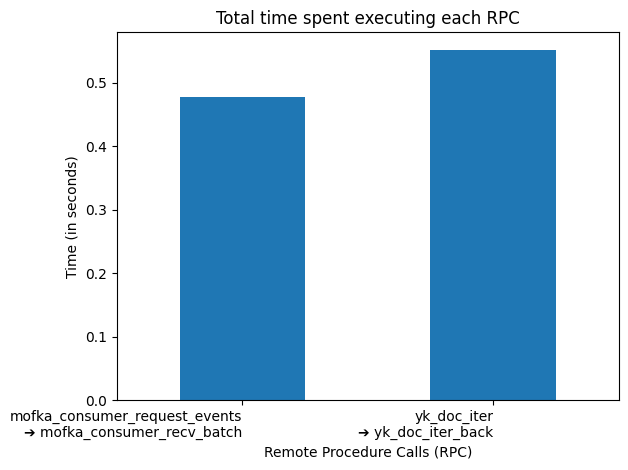

In [8]:
def generate_rpc_time_graph():
    df = ult_duration_sum_df.groupby(["parent_rpc_id", "rpc_id"]).sum()
    print(df)

    new_index = []
    for parent_id, rpc_id in df.index:
        new_index.append(f'{rpc_name[parent_id]}\n{right_arrow} {rpc_name[rpc_id]}')
    
    df.index = new_index
    df.plot(kind='bar')
    plt.title('Total time spent executing each RPC')
    plt.xlabel('Remote Procedure Calls (RPC)')
    plt.ylabel('Time (in seconds)')
    plt.xticks(rotation=0, ha='right')
    plt.tight_layout()
    plt.show()
    
generate_rpc_time_graph()


In [9]:
# ==================== "Total time spent by clients calling this RPC" ====================

# In other words, from iforward_start to iforward_wait_end
# is relative time included?
forward_duration_sum_df = stats.origin_rpc_df['iforward']['duration']['sum'] + stats.origin_rpc_df['iforward_wait']['relative_timestamp_from_iforward_end']['sum'] + stats.origin_rpc_df['iforward_wait']['duration']['sum']
forward_duration_sum_df

file                                     address  name                           rpc_id                provider_id  parent_rpc_id  parent_provider_id  sent_to             
mofka.x3202c0s37b1n0.1873539.stats.json           yk_put_direct                   1170338683618918399  3            65535          65535               ofi+cxi://0x20717a00    0.000138
                                                  yk_coll_create                 -4831825615155822593  3            65535          65535               ofi+cxi://0x20717a00    0.000100
                                                  bedrock_query_config            5386877029230641151  0            65535          65535               ofi+cxi://0x20717a00    0.001490
                                                  __identity__                    7940397281847607295  3            65535          65535               ofi+cxi://0x20717a00    0.000043
mofka.x3202c0s37b1n0.1873541.stats.json           bedrock_start_provider         -4452162136

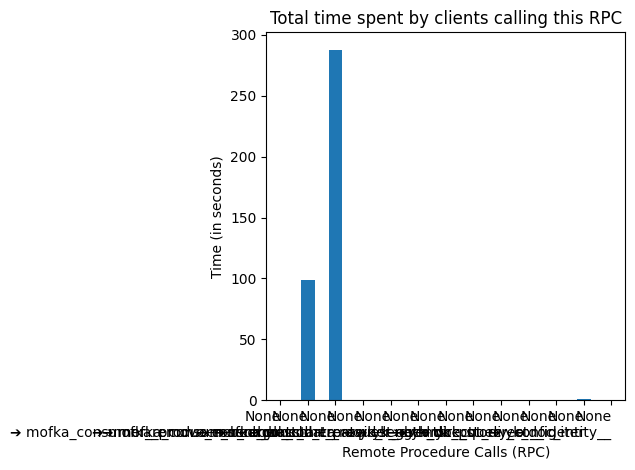

In [10]:
def generate_forward_time_graph():
    df = forward_duration_sum_df.groupby(["parent_rpc_id", "rpc_id"]).sum()
    new_index = []
    for parent_id, rpc_id in df.index:
        new_index.append(f'{rpc_name[parent_id]}\n{right_arrow} {rpc_name[rpc_id]}')
    
    df.index = new_index
    df.plot(kind='bar')
    plt.title('Total time spent by clients calling this RPC')
    plt.xlabel('Remote Procedure Calls (RPC)')
    plt.ylabel('Time (in seconds)')
    plt.xticks(rotation=0, ha='right')
    plt.tight_layout()
    plt.show()
    
generate_forward_time_graph()

In [11]:
# ==================== "Total bulk transfer time for this RPC" ====================
# i.e from itransfer to itransfer_wait_end
transfer_duration_sum_df = stats.bulk_transfer_df['itransfer']['duration']['sum'] + stats.bulk_transfer_df['itransfer_wait']['relative_timestamp_from_itransfer_end']['sum'] + stats.bulk_transfer_df['itransfer_wait']['duration']['sum']

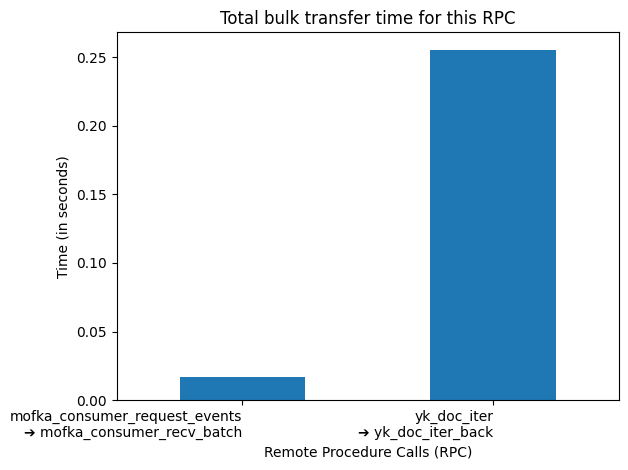

In [12]:
def generate_bulk_transfer_time_graph():
    df = transfer_duration_sum_df.groupby(["parent_rpc_id", "rpc_id"]).sum()

    new_index = []
    for parent_id, rpc_id in df.index:
        new_index.append(f'{rpc_name[parent_id]}\n{right_arrow} {rpc_name[rpc_id]}')
    
    df.index = new_index
    df.plot(kind='bar')
    plt.title('Total bulk transfer time for this RPC')
    plt.xlabel('Remote Procedure Calls (RPC)')
    plt.ylabel('Time (in seconds)')
    plt.xticks(rotation=0, ha='right')
    plt.tight_layout()
    plt.show()
    
generate_bulk_transfer_time_graph()

In [13]:
# ==================== "Total amount of data transferred using RDMA from this RPC" ====================
transfer_size_sum_df = stats.bulk_transfer_df['itransfer']['size']['sum']

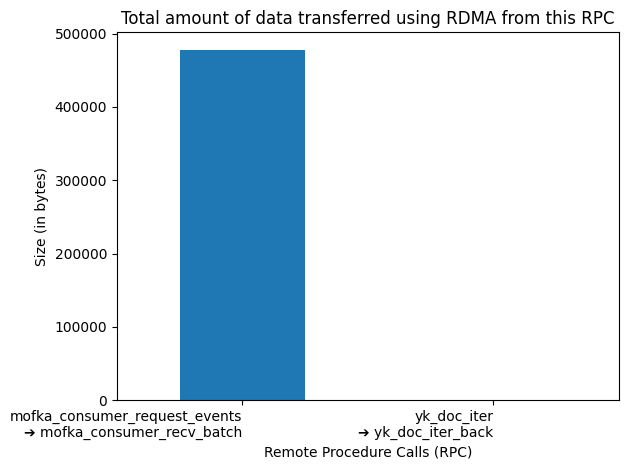

In [14]:
def generate_total_data_from_RDMA_graph():
    df = transfer_size_sum_df.groupby(["parent_rpc_id", "rpc_id"]).sum()

    new_index = []
    for parent_id, rpc_id in df.index:
        new_index.append(f'{rpc_name[parent_id]}\n{right_arrow} {rpc_name[rpc_id]}')
    
    df.index = new_index
    df.plot(kind='bar')
    plt.title('Total amount of data transferred using RDMA from this RPC')
    plt.xlabel('Remote Procedure Calls (RPC)')
    plt.ylabel('Size (in bytes)')
    plt.xticks(rotation=0, ha='right')
    plt.tight_layout()
    plt.show()
    
generate_total_data_from_RDMA_graph()